# Notebook 3 : US data analysis + LDA

In [1]:
import pandas as pd
import numpy as np
import glob
import requests
import json
import tldextract
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
from gensim import corpora, models
nltk.download('stopwords')
SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/meftahzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
news = pd.DataFrame()
DATA_FILES = ['us_part1/newspaper.json','us_part2/newspaper.json' ]
for filepath in DATA_FILES:
    current_news = pd.read_json(filepath, lines=True)
    current_news['country'] = filepath[:2]
    news = news.append(current_news)
    

news.reset_index(inplace=True, drop=True)
news.head()

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
0,Here’s a full list of the 23 Friendly’s locati...,Friendly’s has closed 23 more restaurants arou...,None,[https://www.bostonglobe.com/resizer/thx4EmqY-...,None,en,[],GER_2019-04-08_5182_web_page.html,www.bostonglobe.com/business/2019/04/08/here-f...,NaN,us
1,Yahoo,Yahoo makes it easy to enjoy what matters most...,None,[https://s.yimg.com/rz/d/yahoo_frontpage_maste...,None,None,[],GER_2019-04-08_5398_web_page.html,mail.yahoo.com/,NaN,us
2,Yahoo,Yahoo makes it easy to enjoy what matters most...,None,[https://s.yimg.com/rz/d/yahoo_frontpage_maste...,None,None,[],GER_2019-04-08_5399_web_page.html,mail.yahoo.com/d/folders/1,NaN,us
3,Yahoo,Yahoo makes it easy to enjoy what matters most...,None,[https://s.yimg.com/rz/d/yahoo_frontpage_maste...,None,None,[],GER_2019-04-08_5400_web_page.html,mail.yahoo.com/d/folders/1/messages/ALz5kEB7K0...,NaN,us
4,Yahoo,Yahoo makes it easy to enjoy what matters most...,None,[https://s.yimg.com/rz/d/yahoo_frontpage_maste...,None,None,[],GER_2019-04-08_5401_web_page.html,mail.yahoo.com/d/folders/1/messages/AFokDMRyBc...,NaN,us


In [178]:
len(news)

877033

In [179]:
media_portals= news[(news['meta_lang'] == 'en') | (news['meta_lang'].isnull())] #select only articles with 'en' meta_lang or with empty
len(media_portals)

863167

In [180]:
media_portals=media_portals[media_portals.text.str.contains("SLIDES ©|We did not find results for|\n\nYour link may be a few hours old|Sign up\n\nCreate a Yahoo")==False]
len(media_portals)

530771

In [77]:
media_portals[media_portals.title.str.contains("News & Entertainment by Email")==True]

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts
10128,News & Entertainment by Email,LOS ANGELES -- Andre Moye had been with the Ca...,[Arcamax Publishing],[http://pixel.quantserve.com/pixel/p-720wwH1qg...,None,en,"[free newsletters, online newsletters, email n...",GER_2019-04-08_52471_web_page.html,arcamax.com/reg?trackid=166&key=11776-6430083&...,NaN,us,3,100.0
10129,News & Entertainment by Email,LOS ANGELES -- Andre Moye had been with the Ca...,[Arcamax Publishing],[http://pixel.quantserve.com/pixel/p-720wwH1qg...,None,en,"[free newsletters, online newsletters, email n...",GER_2019-04-08_52472_web_page.html,arcamax.com/reg?trackid=166&key=11776-6430083,NaN,us,3,100.0
10130,News & Entertainment by Email,LOS ANGELES -- Andre Moye had been with the Ca...,[Arcamax Publishing],[http://pixel.quantserve.com/pixel/p-720wwH1qg...,None,en,"[free newsletters, online newsletters, email n...",GER_2019-04-08_52474_web_page.html,arcamax.com,NaN,us,3,100.0
27290,News & Entertainment by Email,MIAMI -- Federal immigration agents are beefin...,[Arcamax Publishing],[http://fox13now.com/newspics/cache/w148h148/1...,None,en,"[free newsletters, online newsletters, email n...",GER_2019-04-10_131332_web_page.html,www.arcamax.com/reg?trackid=166&key=19242-1798...,NaN,us,6,100.0
27291,News & Entertainment by Email,MIAMI -- Federal immigration agents are beefin...,[Arcamax Publishing],[http://fox13now.com/newspics/cache/w148h148/1...,None,en,"[free newsletters, online newsletters, email n...",GER_2019-04-10_131333_web_page.html,www.arcamax.com/reg?trackid=166&key=19242-1798729,NaN,us,6,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
780437,News & Entertainment by Email,LOS ANGELES -- Kanye West's latest stunt? Get ...,[Arcamax Publishing],[http://fox13now.com/newspics/cache/w148h148/1...,None,en,"[free newsletters, online newsletters, email n...",GER_2019-06-05_18404_web_page.html,arcamax.com/cgi-bin/ard?p=A%3A13495859%3AC%3A1...,NaN,us,1,100.0
788668,News & Entertainment by Email,DETROIT -- The UAW's new contract with General...,[Arcamax Publishing],[http://fox13now.com/newspics/cache/w148h148/1...,None,en,"[free newsletters, online newsletters, email n...",GER_2019-06-06_23965_web_page.html,www.arcamax.com/reg?trackid=166&key=413212-300...,NaN,us,4,100.0
788669,News & Entertainment by Email,DETROIT -- The UAW's new contract with General...,[Arcamax Publishing],[http://fox13now.com/newspics/cache/w148h148/1...,None,en,"[free newsletters, online newsletters, email n...",GER_2019-06-06_23966_web_page.html,www.arcamax.com/reg?trackid=166&key=413212-300...,NaN,us,4,100.0
788670,News & Entertainment by Email,DETROIT -- The UAW's new contract with General...,[Arcamax Publishing],[http://fox13now.com/newspics/cache/w148h148/1...,None,en,"[free newsletters, online newsletters, email n...",GER_2019-06-06_23967_web_page.html,www.arcamax.com/reg?trackid=166&key=413212-300...,NaN,us,4,100.0


In [66]:
text_counts = pd.DataFrame(media_portals.text.value_counts())
print(len(text_counts[text_counts['text']<20]))
#text_counts[text_counts['text'].between(0,100)]
text_counts[text_counts['text']==99]

76804


text
Roky Erickson — lead vocalist and principal son...    99

In [67]:
media_portals['txt_counts'] = media_portals['text'].map(media_portals['text'].value_counts())
media_portals['title_counts'] = media_portals['title'].map(media_portals['title'].value_counts())

In [68]:
criteria_text=99
s=media_portals[media_portals['txt_counts']<=criteria_text]
print("Number of articles with text occurence less than "+ str(criteria_text) +" :" + str(len(s)))

Number of articles with text occurence less than 99 :112022


In [75]:
title_counts = pd.DataFrame(media_portals.title.value_counts())
print(len(title_counts[title_counts['title']<20]))
title_counts[title_counts['title'].between(50,100)]
#title_counts[title_counts['title']==20]

68645


,title
Parents Need To Erase These Common Phrases From Their Vocabulary,100
Country music's biggest controversies,100
News & Entertainment by Email,100
The largest employer in each state,99
"Roky Erickson, Legendary Psychedelic Musician, Dies at 71",99
...,...
14 ex-celebrities who ended up with completely different careers,51
The Highest Point in Every State,51
"15 Top-Ranking, Under-$20 Wines According To Real People (Not Critics)",51
Where to Find a Good Cheap Burger in All 50 States,50


In [78]:
criteria_title=100
s=media_portals[media_portals['title_counts']<=criteria_title]
print("Number of articles with text occurence less than "+ str(criteria_title) +" :" + str(len(s)))

Number of articles with text occurence less than 100 :113526


In [79]:
s

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts
0,Here’s a full list of the 23 Friendly’s locati...,Friendly’s has closed 23 more restaurants arou...,None,[https://www.bostonglobe.com/resizer/thx4EmqY-...,None,en,[],GER_2019-04-08_5182_web_page.html,www.bostonglobe.com/business/2019/04/08/here-f...,NaN,us,1,1.0
106,She lived for 99 years with organs in all the ...,"(CNN) On an early spring day in 2018, the fain...",[Sandee Lamotte],[http://cdn.cnn.com/cnnnext/dam/assets/1908111...,None,None,"[health, Rose Marie Bentley lived for 99 years...",GER_2019-04-08_5926_web_page.html,www.cnn.com/2019/04/08/health/99-year-old-back...,NaN,us,2,4.0
107,Scientists just captured a record 17-foot-long...,(CNN) The Burmese python is one of the largest...,[Chandrika Narayan],[http://cdn.cnn.com/cnnnext/dam/assets/1906101...,None,None,"[travel, Python captured in Florida sets a rec...",GER_2019-04-08_5927_web_page.html,www.cnn.com/2019/04/07/us/florida-huge-python-...,NaN,us,3,3.0
108,Jennifer Hart drove family off a cliff as her ...,(CNN) As a drunk Jennifer Hart drove her six a...,"[Madeline Holcombe, Augie Martin]",[https://cdn.cnn.com/cnnnext/dam/assets/180328...,None,None,"[us, Jennifer Hart drove family off a cliff as...",GER_2019-04-08_5928_web_page.html,www.cnn.com/2019/04/06/us/hart-family-crash-in...,NaN,us,4,4.0
109,Timmothy Pitzen's dad hopes news about his mis...,(CNN) Reports that missing boy Timmothy Pitzen...,[Joe Sterling],[http://cdn.cnn.com/cnnnext/dam/assets/1904080...,None,None,"[us, Timmothy Pitzen's dad hopes news about hi...",GER_2019-04-08_5929_web_page.html,www.cnn.com/2019/04/08/us/timmothy-pitzen-case...,NaN,us,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
877019,reddit,TIL that Kyoto was actually at the top of the ...,None,[https://b.thumbs.redditmedia.com/OQmXrWQQsyMe...,None,en,[],GER_2019-06-15_6987_mobile_.html,redd.it/,NaN,us,1,1.0
877020,Sean Hannity: Sources say DOJ inspector genera...,Fox News host Sean Hannity said the Justice De...,None,[https://mediadc.brightspotcdn.com/dims4/defau...,[https://www.youtube.com/embed/JitJqSAZJO8],en,[],GER_2019-06-15_7237_mobile_.html,www.washingtonexaminer.com/news/sean-hannity-s...,NaN,us,1,1.0
877021,I-45 is moving around downtown,EMBED >More News Videos TxDOT has plans to com...,[Katherine Whaley],[https://cdn.abcotvs.com/dip/images/5419417_07...,None,en,"[TxDOT, rebuilding Houston's freeway system, r...",GER_2019-06-15_7546_mobile_.html,abc13.com/traffic/i-45-is-moving-and-it-will-c...,NaN,us,1,1.0
877022,403 Forbidden,Forbidden\n\nYou don't have permission to acce...,None,None,None,None,[],GER_2019-06-15_7626_mobile_.html,static01.nytimes.com/,NaN,us,7,16.0


## Data preprocessing :

In [81]:
a=s
a=a.drop_duplicates(subset='text', keep='first')
a=a.drop_duplicates(subset='title', keep='first')
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts
0,Here’s a full list of the 23 Friendly’s locati...,Friendly’s has closed 23 more restaurants arou...,None,[https://www.bostonglobe.com/resizer/thx4EmqY-...,None,en,[],GER_2019-04-08_5182_web_page.html,www.bostonglobe.com/business/2019/04/08/here-f...,NaN,us,1,1.0
106,She lived for 99 years with organs in all the ...,"(CNN) On an early spring day in 2018, the fain...",[Sandee Lamotte],[http://cdn.cnn.com/cnnnext/dam/assets/1908111...,None,None,"[health, Rose Marie Bentley lived for 99 years...",GER_2019-04-08_5926_web_page.html,www.cnn.com/2019/04/08/health/99-year-old-back...,NaN,us,2,4.0
107,Scientists just captured a record 17-foot-long...,(CNN) The Burmese python is one of the largest...,[Chandrika Narayan],[http://cdn.cnn.com/cnnnext/dam/assets/1906101...,None,None,"[travel, Python captured in Florida sets a rec...",GER_2019-04-08_5927_web_page.html,www.cnn.com/2019/04/07/us/florida-huge-python-...,NaN,us,3,3.0
108,Jennifer Hart drove family off a cliff as her ...,(CNN) As a drunk Jennifer Hart drove her six a...,"[Madeline Holcombe, Augie Martin]",[https://cdn.cnn.com/cnnnext/dam/assets/180328...,None,None,"[us, Jennifer Hart drove family off a cliff as...",GER_2019-04-08_5928_web_page.html,www.cnn.com/2019/04/06/us/hart-family-crash-in...,NaN,us,4,4.0
109,Timmothy Pitzen's dad hopes news about his mis...,(CNN) Reports that missing boy Timmothy Pitzen...,[Joe Sterling],[http://cdn.cnn.com/cnnnext/dam/assets/1904080...,None,None,"[us, Timmothy Pitzen's dad hopes news about hi...",GER_2019-04-08_5929_web_page.html,www.cnn.com/2019/04/08/us/timmothy-pitzen-case...,NaN,us,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
877018,Manhunt underway for armed robbery suspects in...,A manhunt is underway for three men accused of...,None,[https://linkmaker.itunes.apple.com/assets/sha...,None,en,[],GER_2019-06-15_6941_mobile_.html,www.msn.com/en-us/news/crime/manhunt-underway-...,NaN,us,1,1.0
877019,reddit,TIL that Kyoto was actually at the top of the ...,None,[https://b.thumbs.redditmedia.com/OQmXrWQQsyMe...,None,en,[],GER_2019-06-15_6987_mobile_.html,redd.it/,NaN,us,1,1.0
877020,Sean Hannity: Sources say DOJ inspector genera...,Fox News host Sean Hannity said the Justice De...,None,[https://mediadc.brightspotcdn.com/dims4/defau...,[https://www.youtube.com/embed/JitJqSAZJO8],en,[],GER_2019-06-15_7237_mobile_.html,www.washingtonexaminer.com/news/sean-hannity-s...,NaN,us,1,1.0
877021,I-45 is moving around downtown,EMBED >More News Videos TxDOT has plans to com...,[Katherine Whaley],[https://cdn.abcotvs.com/dip/images/5419417_07...,None,en,"[TxDOT, rebuilding Houston's freeway system, r...",GER_2019-06-15_7546_mobile_.html,abc13.com/traffic/i-45-is-moving-and-it-will-c...,NaN,us,1,1.0


## Delete handles, image caption/credits, links, money amounts, phone numbers, and navigation menus

In [82]:
r_ignore_case = {
    'handle': r'\S+@\S+',
    'link': r'((visit|at)\s+)*(\S+).(com|org)((/|\S)*)',
    'money': r'\$\d*',
    'phone': r'(\d-)*(\d+-\d+-\d+)' ,
    'menu': r'(?<=•)[^•]*(?=•)'
}
r_set_case = {
    'photographer-credits': r'PHOTO(GRAPHER)*:(\s)*(([A-Z][A-Za-z]*)\s*){1,3}',
    'graphics': r'Graphic([^.])'
}

In [83]:
def filter_text(text):
    for regex in r_ignore_case:
        text = re.sub(regex, '', text, re.I)
    for regex in r_set_case:
        text = re.sub(regex, '', text)
    return text

In [84]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return [stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in text]

In [85]:
def process_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    return text

In [86]:
url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text))
SW = list(response['words'])
def remove_stopwords(text):
    return [word for word in text if not word in SW]

In [91]:
def clean_text(text):
    text = filter_text(text)
    text = process_text(text)
    text = remove_stopwords(text)
    text = lemmatize_stemming(text)
    return text

In [92]:
a["combined"]= a["title"]+a["text"]

In [93]:
a['clean_text']=a['combined'].apply(lambda x: clean_text(str(x)))

In [94]:
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,combined,clean_text
0,Here’s a full list of the 23 Friendly’s locati...,Friendly’s has closed 23 more restaurants arou...,None,[https://www.bostonglobe.com/resizer/thx4EmqY-...,None,en,[],GER_2019-04-08_5182_web_page.html,www.bostonglobe.com/business/2019/04/08/here-f...,NaN,us,1,1.0,Here’s a full list of the 23 Friendly’s locati...,"[list, friendli, locat, close, northeast, incl..."
106,She lived for 99 years with organs in all the ...,"(CNN) On an early spring day in 2018, the fain...",[Sandee Lamotte],[http://cdn.cnn.com/cnnnext/dam/assets/1908111...,None,None,"[health, Rose Marie Bentley lived for 99 years...",GER_2019-04-08_5926_web_page.html,www.cnn.com/2019/04/08/health/99-year-old-back...,NaN,us,2,4.0,She lived for 99 years with organs in all the ...,"[live, year, organ, wrong, place, know, cnn, e..."
107,Scientists just captured a record 17-foot-long...,(CNN) The Burmese python is one of the largest...,[Chandrika Narayan],[http://cdn.cnn.com/cnnnext/dam/assets/1906101...,None,None,"[travel, Python captured in Florida sets a rec...",GER_2019-04-08_5927_web_page.html,www.cnn.com/2019/04/07/us/florida-huge-python-...,NaN,us,3,3.0,Scientists just captured a record 17-foot-long...,"[scientist, captur, record, foot, long, python..."
108,Jennifer Hart drove family off a cliff as her ...,(CNN) As a drunk Jennifer Hart drove her six a...,"[Madeline Holcombe, Augie Martin]",[https://cdn.cnn.com/cnnnext/dam/assets/180328...,None,None,"[us, Jennifer Hart drove family off a cliff as...",GER_2019-04-08_5928_web_page.html,www.cnn.com/2019/04/06/us/hart-family-crash-in...,NaN,us,4,4.0,Jennifer Hart drove family off a cliff as her ...,"[jennif, hart, drive, famili, cliff, wife, loo..."
109,Timmothy Pitzen's dad hopes news about his mis...,(CNN) Reports that missing boy Timmothy Pitzen...,[Joe Sterling],[http://cdn.cnn.com/cnnnext/dam/assets/1904080...,None,None,"[us, Timmothy Pitzen's dad hopes news about hi...",GER_2019-04-08_5929_web_page.html,www.cnn.com/2019/04/08/us/timmothy-pitzen-case...,NaN,us,1,1.0,Timmothy Pitzen's dad hopes news about his mis...,"[timmothi, pitzen, dad, hop, news, miss, son, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877018,Manhunt underway for armed robbery suspects in...,A manhunt is underway for three men accused of...,None,[https://linkmaker.itunes.apple.com/assets/sha...,None,en,[],GER_2019-06-15_6941_mobile_.html,www.msn.com/en-us/news/crime/manhunt-underway-...,NaN,us,1,1.0,Manhunt underway for armed robbery suspects in...,"[manhunt, underway, arm, robberi, suspect, bur..."
877019,reddit,TIL that Kyoto was actually at the top of the ...,None,[https://b.thumbs.redditmedia.com/OQmXrWQQsyMe...,None,en,[],GER_2019-06-15_6987_mobile_.html,redd.it/,NaN,us,1,1.0,redditTIL that Kyoto was actually at the top o...,"[reddittil, kyoto, list, target, atom, bomb, n..."
877020,Sean Hannity: Sources say DOJ inspector genera...,Fox News host Sean Hannity said the Justice De...,None,[https://mediadc.brightspotcdn.com/dims4/defau...,[https://www.youtube.com/embed/JitJqSAZJO8],en,[],GER_2019-06-15_7237_mobile_.html,www.washingtonexaminer.com/news/sean-hannity-s...,NaN,us,1,1.0,Sean Hannity: Sources say DOJ inspector genera...,"[sean, hanniti, sourc, doj, inspector, gener, ..."
877021,I-45 is moving around downtown,EMBED >More News Videos TxDOT has plans to com...,[Katherine Whaley],[https://cdn.abcotvs.com/dip/images/5419417_07...,None,en,"[TxDOT, rebuilding Houston's freeway system, r...",GER_2019-06-15_7546_mobile_.html,abc13.com/traffic/i-45-is-moving-and-it-will-c...,NaN,us,1,1.0,I-45 is moving around downtownEMBED >More News...,"[move, downtownemb, news, video, txdot, plan, ..."


In [95]:
a['length']=a['clean_text'].apply(lambda x: len(x))

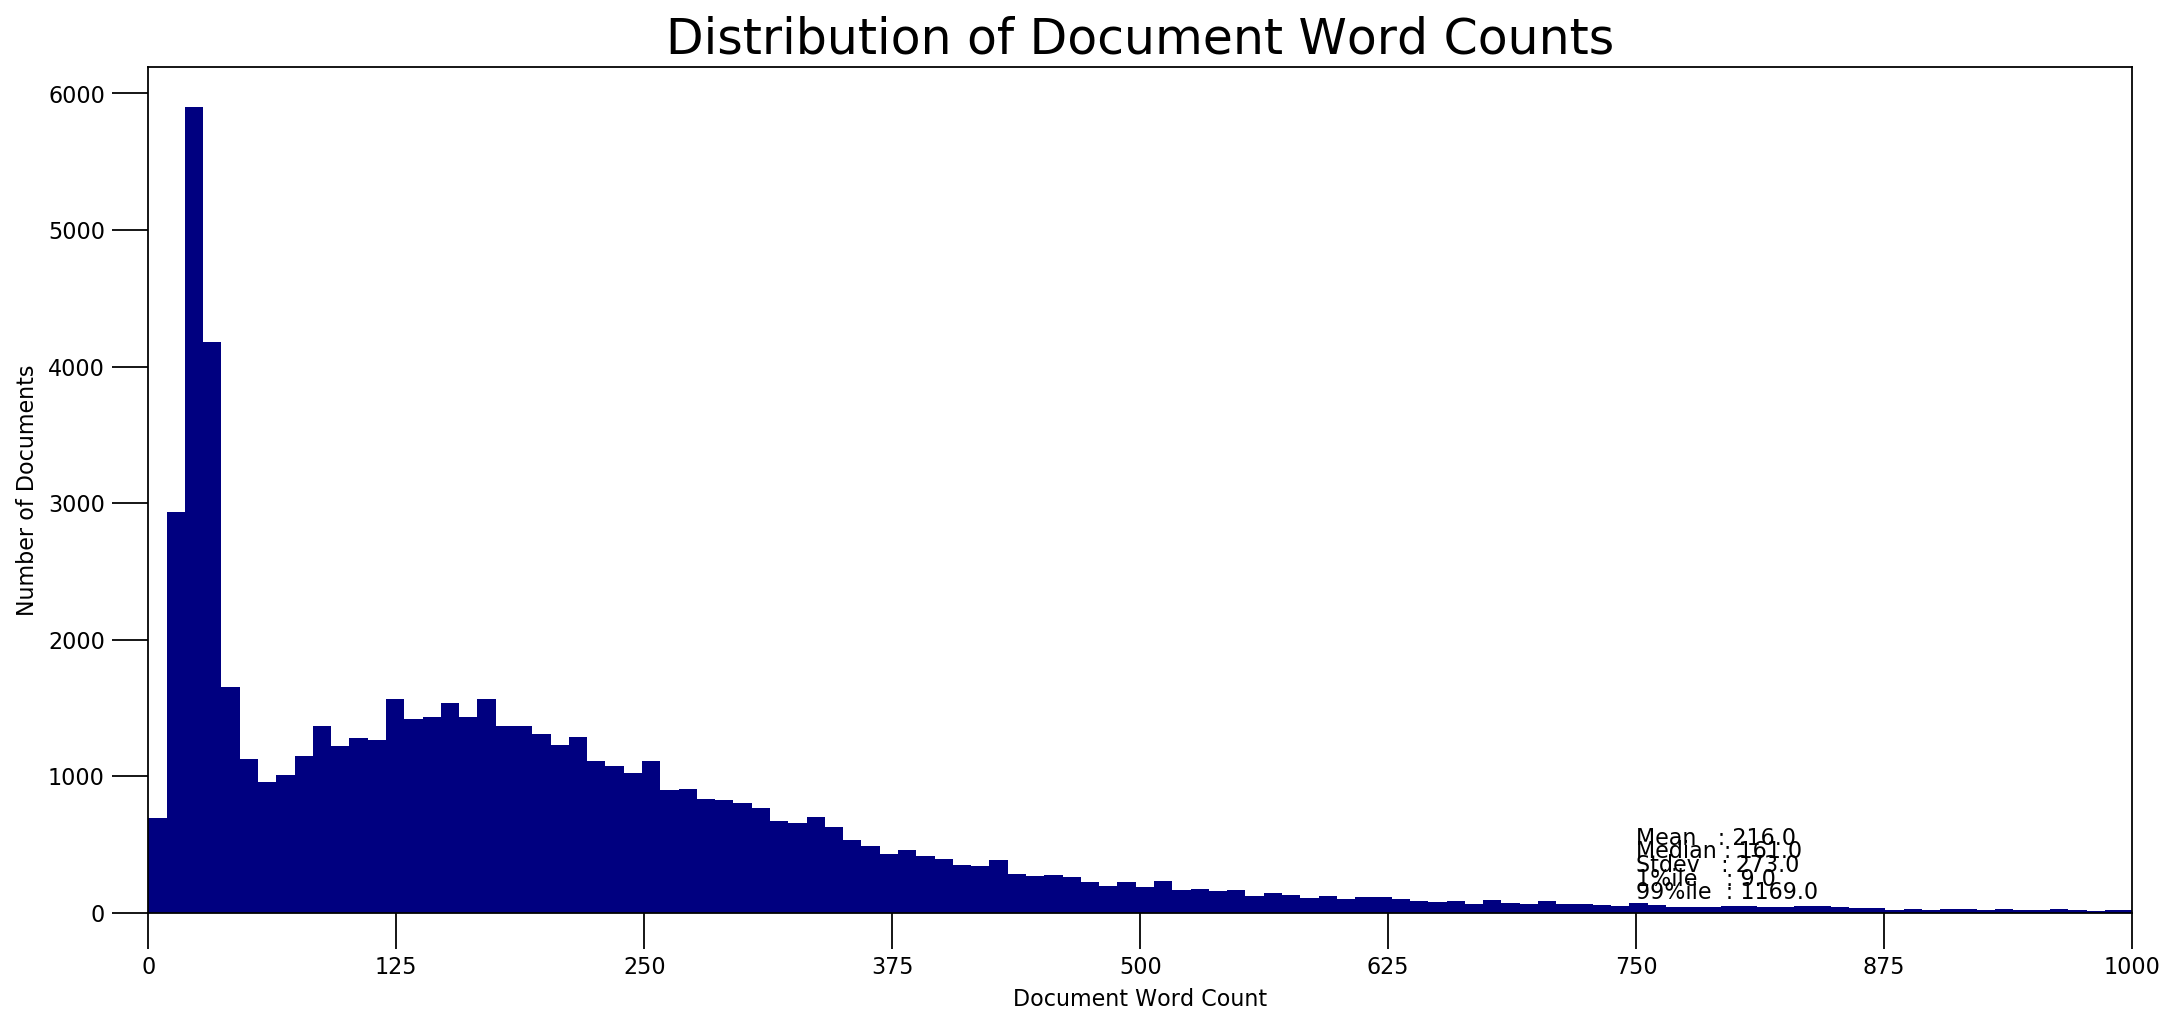

In [97]:
doc_lens = list(a["length"])

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 500, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  400, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  300, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  200, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  100, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [100]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'imag', 'de', 'en', 'caption', 'also', 'copyright', 'something', 
                   'nh', "getti", "pa","don","ap","afp","reuter","pictur", "ve", "didn", "share","septemb",
                   "august","octob","jo","thoma","june","juli","fox","bu","yahoo"
                  "st","ms"]
my_stopwords = SW + stopwords_verbs + stopwords_other

a['clean_text']= a['clean_text'].map(lambda tokens: [token for token in tokens if token not in my_stopwords])

In [102]:
a[a["length"]<50]

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,combined,clean_text,length
0,Here’s a full list of the 23 Friendly’s locati...,Friendly’s has closed 23 more restaurants arou...,None,[https://www.bostonglobe.com/resizer/thx4EmqY-...,None,en,[],GER_2019-04-08_5182_web_page.html,www.bostonglobe.com/business/2019/04/08/here-f...,NaN,us,1,1.0,Here’s a full list of the 23 Friendly’s locati...,"[list, friendli, locat, close, northeast, incl...",17
124,Motorcyclist panics and painfully dumps his ride,"A rider from Las Vegas, Nevada, shared footage...",None,[http://googleads.g.doubleclick.net/pagead/vie...,None,en,[],GER_2019-04-08_6641_web_page.html,nypost.com/video/motorcyclist-panics-and-painf...,NaN,us,1,1.0,Motorcyclist panics and painfully dumps his ri...,"[motorcyclist, panic, pain, dump, ridea, rider...",25
137,safesearch.norton.com Yahoo Search Results,The average price for real estate on Arlene Ci...,None,[https://s.yimg.com/pv/static/img/yahoo_purple...,None,en,[],GER_2019-04-08_6839_web_page.html,search.yahoo.com/yhs/search?type=cr_hp_zeus_wk...,NaN,us,1,13.0,safesearch.norton.com Yahoo Search ResultsThe ...,"[safesearch, norton, yahoo, search, resultsth,...",36
143,"Shows, Episodes, Schedule",We and our partners use cookies on this site t...,None,[https://www.nbc.com/generetic/images/nbc_logo...,None,en,[],GER_2019-04-08_6848_web_page.html,www.nbc.com/,NaN,us,561,4.0,"Shows, Episodes, ScheduleWe and our partners u...","[episod, schedulew, partner, cooki, site, impr...",27
151,Fox News,"This material may not be published, broadcast,...",None,[https://a57.foxnews.com/media2.foxnews.com/Br...,None,en,[],GER_2019-04-08_6917_web_page.html,www.foxnews.com/us,NaN,us,37,34.0,"Fox NewsThis material may not be published, br...","[newsthi, materi, publish, broadcast, rewrit, ...",17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876621,will the iphone 6s get ios 13,MSN News\n\n· 7 days ago\n\nIndia is one of th...,None,[https://s.yimg.com/fz/api/res/1.2/3VpsYrn_0H_...,None,en,[],GER_2019-06-15_66458_web_page.html,search.yahoo.com/yhs/search?hspart=iba&hsimp=y...,NaN,us,1,1.0,will the iphone 6s get ios 13MSN News\n\n· 7 d...,"[io, msn, news, day, india, market, discontinu...",9
876679,News 12 The Bronx,Most Popular Stories Most Popular Stories More...,None,[http://news12.cv.net/data/news/images/watch-n...,None,en,[],GER_2019-06-15_67266_web_page.html,bronx.news12.com/,NaN,us,1,1.0,News 12 The BronxMost Popular Stories Most Pop...,"[news, bronxmost, popular, stori, popular, sto...",34
876909,Machete killing of Bronx teen in case of mista...,Machete killing of Bronx teen in case of mista...,"[Minyvonne Burke, Minyvonne Burke Is A Breakin...",[https://media2.s-nbcnews.com/j/newscms/2019_2...,None,en,[],GER_2019-06-15_69245_web_page.html,www.nbcnews.com/news/crime-courts/machete-kill...,NaN,us,1,1.0,Machete killing of Bronx teen in case of mista...,"[machet, kill, bronx, teen, case, mistak, iden...",29
876987,"Los Angeles News, Local News, Weather, Traffic...",Treasures from the Doris Day Estate Go to Auction,None,[http://media.nbclosangeles.com/images/life-co...,None,en,"[los angeles, la breaking news, la traffic, la...",GER_2019-06-15_119_mobile_.html,www.nbclosangeles.com/,NaN,us,1,1.0,"Los Angeles News, Local News, Weather, Traffic...","[lo, angel, news, local, news, weather, traffi...",14


In [103]:
a=a[a["length"]>50]

In [104]:
data_lemmatized = list(a['clean_text'])

In [105]:
bigram = gensim.models.Phrases(data_lemmatized, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

texts = [bigram_mod[doc] for doc in data_lemmatized]

In [106]:
# Create Dictionary
id2word = corpora.Dictionary(texts)
# Filter out words that occur less than 30 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=1, no_above=0.4)

# Create Corpus
texts = texts

In [107]:
corpus = [id2word.doc2bow(text) for text in texts]

In [108]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 100000
Number of documents: 46826


### Crime  - Economic situation - Rising prices/inflation/cost of living - Taxation - Unemployment - Terrorism - Housing - Government debt - Immigration - Health and social security - The education system - Pensions - The environment, climate and energy issues  - Brexit

## Build LDA model

In [110]:
numberoftopics= list(range(14, 26))
numberoftopics

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [111]:
# Build LDA model
coherence_values = []
model_list = []
perplexity_values =[]
for i in numberoftopics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= i , 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=1000,
                                                   passes=2)
    model_list.append(lda_model)

    print("------------------------------------------------")
    print("number of topics" , i)
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))
    perplexity_values.append(lda_model.log_perplexity(corpus))
    print(lda_model.print_topics())
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    print('\nCoherence Score: ', coherence_lda)

------------------------------------------------
number of topics 14

Perplexity:  -9.451728961797691
[(0, '0.057*"trump" + 0.025*"presid" + 0.018*"hous" + 0.015*"investig" + 0.015*"mueller" + 0.009*"white" + 0.009*"democrat" + 0.009*"fbi" + 0.008*"impeach" + 0.008*"depart"'), (1, '0.027*"court" + 0.021*"case" + 0.019*"charg" + 0.016*"alleg" + 0.014*"file" + 0.013*"attorney" + 0.013*"prison" + 0.013*"judg" + 0.012*"sentenc" + 0.011*"prosecutor"'), (2, '0.010*"mexico" + 0.009*"law" + 0.009*"govern" + 0.008*"countri" + 0.008*"nation" + 0.007*"unit" + 0.007*"offici" + 0.007*"border" + 0.007*"american" + 0.007*"group"'), (3, '0.024*"polic" + 0.011*"offic" + 0.010*"shoot" + 0.010*"man" + 0.009*"famili" + 0.009*"kill" + 0.009*"death" + 0.008*"investig" + 0.007*"news" + 0.007*"die"'), (4, '0.013*"school" + 0.009*"student" + 0.008*"women" + 0.008*"life" + 0.007*"work" + 0.006*"stori" + 0.006*"men" + 0.005*"feel" + 0.005*"charact" + 0.005*"live"'), (5, '0.018*"tax" + 0.017*"percent" + 0.015*"pa

'''finding the optimal number of topics is to build
many LDA models with different values of number of topics (k) 
and pick the one that gives the highest coherence value.
Best coherence for umass is typically the minimum
'''

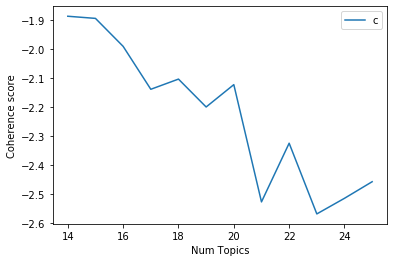

In [113]:
# Show graph
limit=26; start=14; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

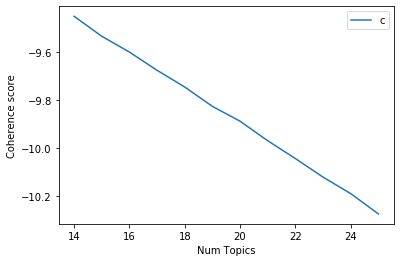

In [114]:
# Show graph
limit=26; start=14; step=1;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [117]:
for i,topic in model_list[-3].show_topics(formatted=True, num_topics=25, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.091*"trump" + 0.042*"presid" + 0.016*"white" + 0.016*"news" + 0.014*"donald" + 0.011*"hous" + 0.007*"media" + 0.007*"meet" + 0.007*"tweet" + 0.007*"polit"

1: 0.019*"famili" + 0.013*"children" + 0.012*"child" + 0.011*"mother" + 0.010*"prison" + 0.010*"father" + 0.009*"daughter" + 0.008*"court" + 0.008*"sex" + 0.008*"life"

2: 0.019*"mexico" + 0.013*"border" + 0.011*"govern" + 0.010*"unit" + 0.010*"militari" + 0.010*"countri" + 0.010*"iran" + 0.010*"immigr" + 0.009*"nation" + 0.009*"administr"

3: 0.035*"polic" + 0.016*"offic" + 0.014*"shoot" + 0.013*"kill" + 0.012*"man" + 0.010*"investig" + 0.010*"death" + 0.009*"attack" + 0.008*"car" + 0.008*"arrest"

4: 0.061*"school" + 0.037*"student" + 0.016*"high" + 0.016*"parent" + 0.015*"colleg" + 0.013*"univers" + 0.011*"children" + 0.011*"graduat" + 0.011*"teacher" + 0.010*"commun"

5: 0.053*"trump" + 0.032*"hous" + 0.028*"mueller" + 0.027*"presid" + 0.022*"democrat" + 0.019*"impeach" + 0.016*"investig" + 0.013*"congress" + 0.013*"committ

In [196]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
lda_model = model_list[-3]

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18    -0.131552  0.120051       1        1  9.652704
19     0.024537 -0.175221       2        1  6.066134
15    -0.071120  0.070756       3        1  6.045719
3      0.027306  0.139520       4        1  6.035804
16     0.189813 -0.019662       5        1  5.761384
8      0.051903  0.085906       6        1  4.995162
0      0.155118  0.013572       7        1  4.934119
11     0.126701 -0.053934       8        1  4.928179
10    -0.088567 -0.007284       9        1  4.852911
12    -0.083845  0.024027      10        1  4.748879
9     -0.124251 -0.135898      11        1  4.696551
5      0.225368 -0.033363      12        1  4.348063
6     -0.006882 -0.084347      13        1  4.337318
2      0.164058 -0.107233      14        1  4.108492
1      0.081139  0.172183      15        1  4.005081
20    -0.042841 -0.160373      16        1  3.591506
21    -0.064767 -0.000581      17        1  3.288791
17    -0.192833 -0.140510      18        1  3.135005
4      0.052668  0.079962      19        1  2.768739
14    -0.067391  0.192295      20        1  2.655423
7     -0.242604 -0.116270      21        1  2.205017
22     0.136167 -0.066811      22        1  1.923308
13    -0.118125  0.203216      23        1  0.915711, topic_info=          Term          Freq         Total Category  logprob  loglift
927      trump  88791.000000  88791.000000  Default  30.0000  30.0000
867     presid  48286.000000  48286.000000  Default  29.0000  29.0000
1469  democrat  31513.000000  31513.000000  Default  28.0000  28.0000
2022    school  20190.000000  20190.000000  Default  27.0000  27.0000
446      polic  25052.000000  25052.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
891    countri   1313.130005  18059.667969  Topic23  -4.4051   2.0720
8335      adam    650.178467   1897.383911  Topic23  -5.1080   3.6222
1822     music    820.349915   6136.558594  Topic23  -4.8755   2.6809
1384   announc    627.640259  10783.436523  Topic23  -5.1433   1.8494
690      april    591.513855   8564.231445  Topic23  -5.2025   2.0206

[1732 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
18065     17  0.998279      abe
822        1  0.047128   aboard
822        9  0.950099   aboard
5747      22  0.999893    abort
306        3  0.001072     abus
...      ...       ...      ...
9335      19  0.014096   youtub
11111      4  0.009545  zealand
11111      7  0.019090  zealand
11111     17  0.954507  zealand
11111     20  0.015908  zealand

[9166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 20, 16, 4, 17, 9, 1, 12, 11, 13, 10, 6, 7, 3, 2, 21, 22, 18, 5, 15, 8, 23, 14])

In [120]:
max(lda_model.get_document_topics(corpus[0]))
l=[]
for i in range(len(data_lemmatized)):
    l.append(max(lda_model.get_document_topics(corpus[i]), key=lambda x:x[1]))

usage of LDA is when you have no labels, and you want to identify which documents are semantically similar to each other, without necessarily determining what the correct class label for the documents is.

In [121]:
a["topic_prob"]= l

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [122]:
# Number of Documents for Each Topic
topi = a['topic_prob'].apply(lambda x: x[0])
topic_perce= a['topic_prob'].apply(lambda x: x[1])
topic_counts=topi.value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show

df_dominant_topics['dominant_topic'] = df_dominant_topics.index
df_dominant_topics

,Num_Documents,Perc_Documents,dominant_topic
18,5835,0.1246,18
3,4470,0.0955,3
12,3058,0.0653,12
15,2833,0.0605,15
11,2396,0.0512,11
5,2308,0.0493,5
10,2232,0.0477,10
16,2171,0.0464,16
0,2152,0.0460,0
8,2144,0.0458,8


In [123]:
import matplotlib.colors as mcolors
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

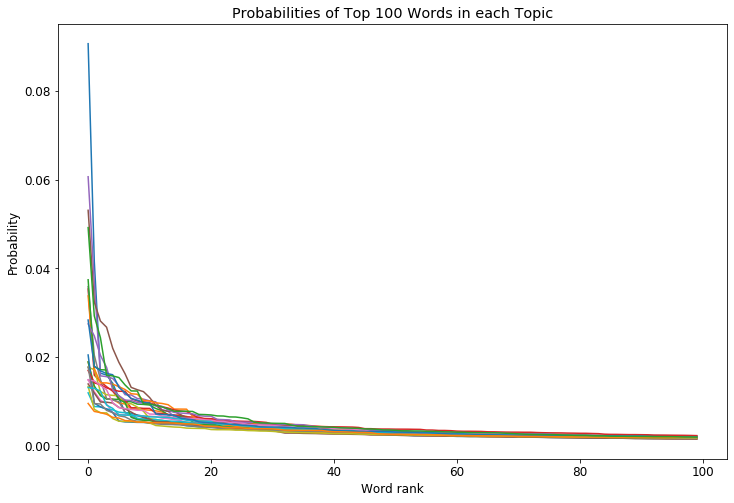

In [124]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 12, 8 
plt.rcParams['font.size'] = 12

# top 100 words by weight in each topic
top_n_words = 100
topics = lda_model.show_topics(
    num_topics = 23, num_words = top_n_words, formatted = False)

for _, infos in topics:
    probs = [prob for _, prob in infos]
    plt.plot(range(top_n_words), probs)

plt.xlabel('Word rank')
plt.ylabel('Probability')
plt.title('Probabilities of Top 100 Words in each Topic')
plt.show()

In [125]:
sent_topics_df = a[["clean_text"]]

In [126]:
sent_topics_df["topic"]= a['topic_prob'].map(lambda token: token[0])
sent_topics_df["Perc_Contribution"]= a['topic_prob'].map(lambda token: token[1])

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [127]:
def kew(topic_num):
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    return(topic_keywords)

In [128]:
sent_topics_df["topic_keywords"]= sent_topics_df["topic"].map(lambda token: kew(token))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [129]:
def closest(topic_num, doc_num):
    v= sent_topics_df[sent_topics_df["topic"]==topic_num]
    v= v.nlargest(doc_num, 'Perc_Contribution')
    return(v)

In [190]:
new_list=closest(1,1)
new_list= new_list.reset_index()

In [191]:
new_list["topic_keywords"][0]

'famili, children, child, mother, prison, father, daughter, court, sex, life'

In [194]:
topic_labels ={0:"Trump",1:"Child Abuse",2:"Immigration",
               3:"Crime",4:"Education",5:"Trump impeachment",6:"Health",
               7:"Food recipes",8:"Social Media",
               9:"Shopping",10:"Weather forecast",11:"Campaigns",12:"Sports",13:"The voice",14:"Royal family",
              15:"movies and tv shows",16:"FBI, NSA investigations", 17:"Skin Care",18:"Celebrity",19:"Taxation",
              20:"Finance",21:"Protests",22:"laws and bills"}
empt=[]
for i in sent_topics_df['topic'].value_counts().index:
    empt.append(topic_labels[i])
sent_topics_df['topic'].value_counts()

18    5835
3     4470
12    3058
15    2833
11    2396
5     2308
10    2232
16    2171
0     2152
8     2144
19    2086
9     1858
2     1830
6     1803
1     1633
20    1605
14    1271
4     1234
17    1223
7      984
21     966
22     691
13      43
Name: topic, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text xticklabel objects>)

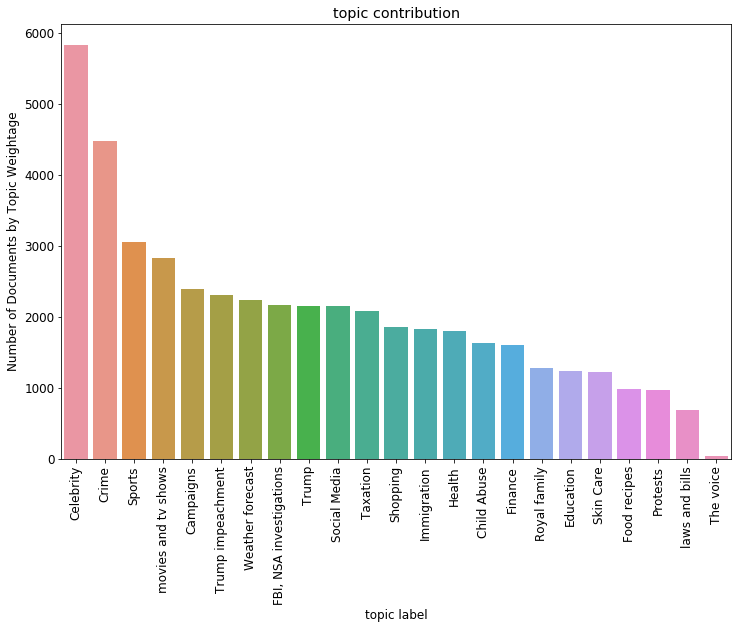

In [195]:
import seaborn 
ax=seaborn.barplot(x=empt, y=sent_topics_df['topic'].value_counts())
ax.set_title('topic contribution')
ax.set_ylabel('Number of Documents by Topic Weightage')
ax.set_xlabel('topic label')
plt.xticks(rotation=90)